In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt

In [2]:
mask = hp.read_map("/global/project/projectdirs/sobs/www/users/Radio_WebSky/" + 
                   "radio_apodized_15arcmin_7mJy_cut_at_143Ghz_mask.fits")
nside = hp.npix2nside(len(mask))

/global/homes/x/xzackli/.conda/envs/pysmdev/lib/python3.10/site-packages/healpy/visufunc.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/global/homes/x/xzackli/.conda/envs/pysmdev/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


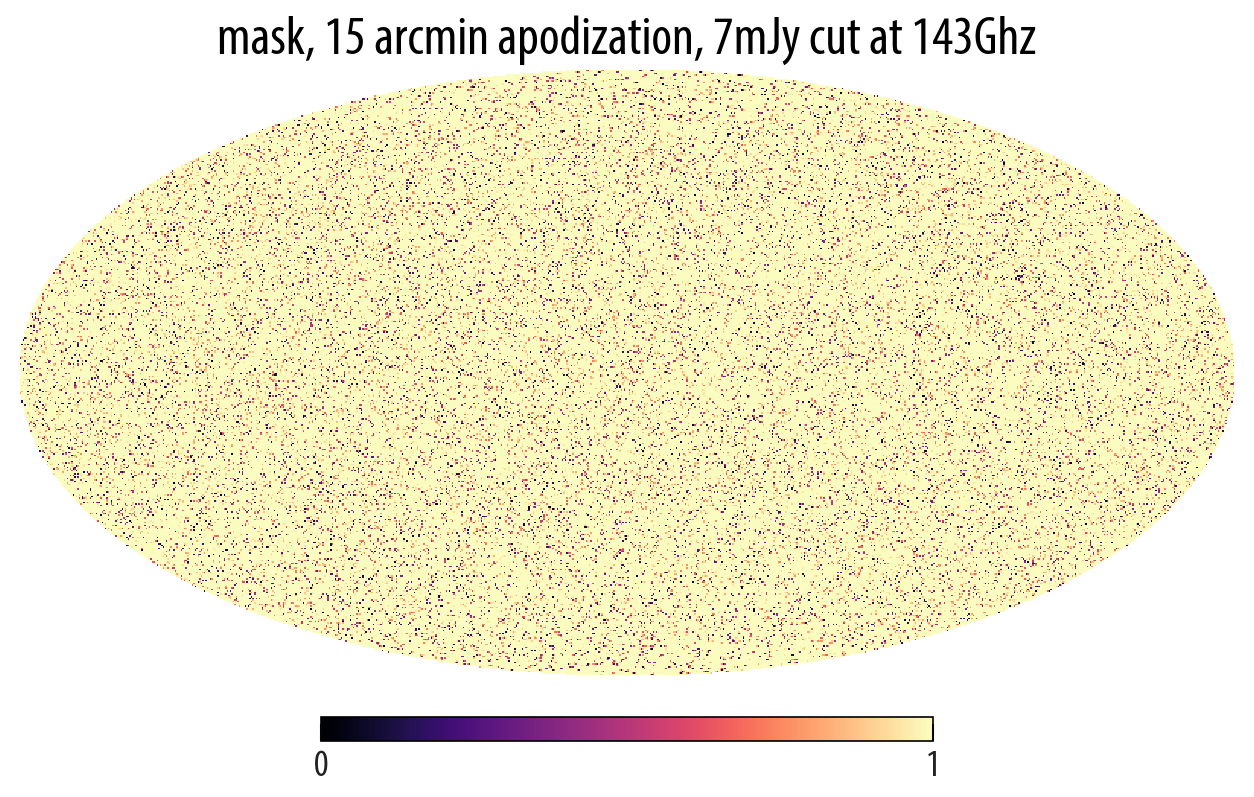

In [3]:
hp.mollview(mask, title="mask, 15 arcmin apodization, 7mJy cut at 143Ghz")

In [4]:
radio_map_file = "/global/project/projectdirs/cmb/www/" + \
    "pysm-data/websky/0.4/radio/radio_0143.0.fits"
cib_map_file = "/global/project/projectdirs/cmb/www/" + \
    "pysm-data/websky/0.4/cib/cib_0143.0.fits"
y_map_file = "/global/project/projectdirs/cmb/www/" + \
    "pysm-data/websky/0.4/tsz_8192_hp.fits"

In [5]:
radio_map = hp.read_map(radio_map_file, field=0)
cib_map = hp.read_map(cib_map_file, field=0)
y_map = hp.pixelfunc.ud_grade(  # slow because nside 8192 on disk
    hp.read_map(y_map_file, field=0), nside)

In [6]:
from astropy import units as u
from astropy.constants import k_B, h

def xf(nu):
    return h * nu / k_B / (2.725 * u.K)

def y_to_muK(nu):
    factor = (2.725e6) * (xf(nu) * (np.exp(xf(nu))+1) / np.expm1(xf(nu)) - 4)
    return (factor + 0.).value  # add zero for dimensionless

def Jy_to_muK(nu):
    factor = 1.05e-3 * np.expm1(xf(nu))**2 * np.exp(-xf(nu)) * (nu / (100 * u.GHz))**(-4)
    return (factor + 0.).value

In [7]:
freq = 143 * u.GHz

# delta function bandpasses, convert to muK
tsz_map = y_map * y_to_muK(freq)
radio_muK_map = radio_map * Jy_to_muK(freq)
cib_muK_map = cib_map * Jy_to_muK(freq)

In [8]:
# compute SHTs of masked fields
f_tsz = nmt.NmtField(mask, [tsz_map])
f_radio = nmt.NmtField(mask, [radio_muK_map])
f_cib = nmt.NmtField(mask, [cib_muK_map])
b = nmt.NmtBin.from_nside_linear(nside, 4)

In [9]:
# compute mode-coupling matrix (mcm is the same for all)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f_tsz, f_tsz, b)

In [10]:
pcl_tsz_tsz = nmt.compute_coupled_cell(f_tsz, f_tsz)
pcl_radio_radio = nmt.compute_coupled_cell(f_radio, f_radio)
pcl_cib_cib = nmt.compute_coupled_cell(f_cib, f_cib)

# Decouple power spectrum into bandpowers inverting the coupling matrix
cl_tsz_tsz = w.decouple_cell(pcl_tsz_tsz)[0]
cl_radio_radio = w.decouple_cell(pcl_radio_radio)[0]
cl_cib_cib = w.decouple_cell(pcl_cib_cib)[0]

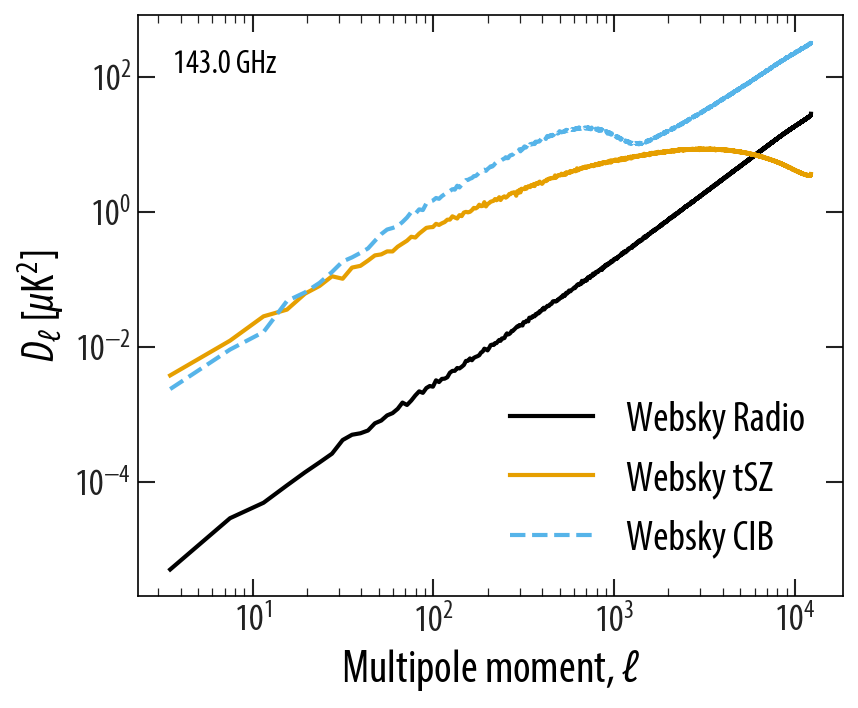

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.text(0.05,0.9,f"{freq}", transform=plt.gca().transAxes)

lb = b.get_effective_ells()
Dl_factor = lb * (lb + 1) / (2 * np.pi)

plt.plot(lb, cl_radio_radio * Dl_factor, "-", label="Websky Radio")
plt.plot(lb, cl_tsz_tsz * Dl_factor  , "-", label="Websky tSZ")
plt.plot(lb, cl_cib_cib * Dl_factor * 1e12, "--", label="Websky CIB")

plt.xlabel(r"Multipole moment, $\ell$")
plt.ylabel(r"$D_{\ell}$ [$\mu$K$^2$]")

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()